In [103]:
import sys
sys.path.append("../src")
import pandas as pd
import matplotlib.pyplot as plt
from simple_CAPM import run_capm_pipeline


# Liste initiale des tickers (exemple de 20 tickers)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 'MA', 'DIS', 'HD', 'BAC', 'XOM', 'CVX', 'UNH', 'PFE']

# Ajouter 30 tickers supplémentaires
additional_tickers = ['INTC', 'CSCO', 'ADBE', 'NFLX', 'PYPL', 'T', 'VZ', 'CRM', 'CMCSA', 'PEP',
                      'KO', 'MRK', 'ABT', 'NKE', 'ORCL', 'MCD', 'TXN', 'COST', 'LIN', 'QCOM',
                      'LOW', 'UPS', 'BMY', 'AMD', 'GE', 'IBM', 'CAT', 'MDT', 'GS', 'MMM']

# Fusionner les listes
tickers = list(set(tickers + additional_tickers))


# Marché de ref
benchmark = "^GSPC"
start = "2024-07-01"
end = "2025-07-01"
expected_market_return = 0.08 
risk_free_rate = 0.02

#pipeline CAPM
betas, expected_returns, cov_matrix = run_capm_pipeline(
    tickers=tickers,
    benchmark=benchmark,
    start=start,
    end=end,
    expected_market_return=expected_market_return,
    risk_free_rate=risk_free_rate
)

print("Betas :\n", pd.Series(betas).sort_values(ascending=False).head())
print("\nRendements attendus CAPM :\n", expected_returns.sort_values(ascending=False).head())


[*********************100%***********************]  51 of 51 completed


Betas :
 TSLA    2.498630
NVDA    2.154737
AMD     2.039412
INTC    1.815781
QCOM    1.644230
dtype: float64

Rendements attendus CAPM :
 TSLA    0.169918
NVDA    0.149284
AMD     0.142365
INTC    0.128947
QCOM    0.118654
dtype: float64


In [105]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Fonction d'utilité Markowitz (à minimiser avec un signe moins)
def markowitz_utility(w, mu, cov, risk_aversion):
    # U(w) = w^T mu - 0.5 * lambda * w^T cov w
    return -(np.dot(w, mu) - 0.5 * risk_aversion * np.dot(w, np.dot(cov, w)))

# Paramètres
n_assets = len(expected_returns)
risk_aversion = 5  # Coefficient d'aversion au risque (modifiable)

# Contraintes : somme des poids = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bornes pour chaque poids
bounds = tuple((0, 0.05) for _ in range(n_assets))

# Point initial : poids uniformes
w0 = np.ones(n_assets) / n_assets

# Optimisation
opt_result = minimize(
    markowitz_utility,
    w0,
    args=(expected_returns.values, cov_matrix.values, risk_aversion),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

if opt_result.success:
    optimal_weights = pd.Series(opt_result.x, index=expected_returns.index)
    print("Poids optimaux :")
    print(optimal_weights.sort_values(ascending=False).head())
else:
    print("L'optimisation a échouée :", opt_result.message)


Poids optimaux :
PYPL     0.05
GOOGL    0.05
TSLA     0.05
CAT      0.05
MMM      0.05
dtype: float64


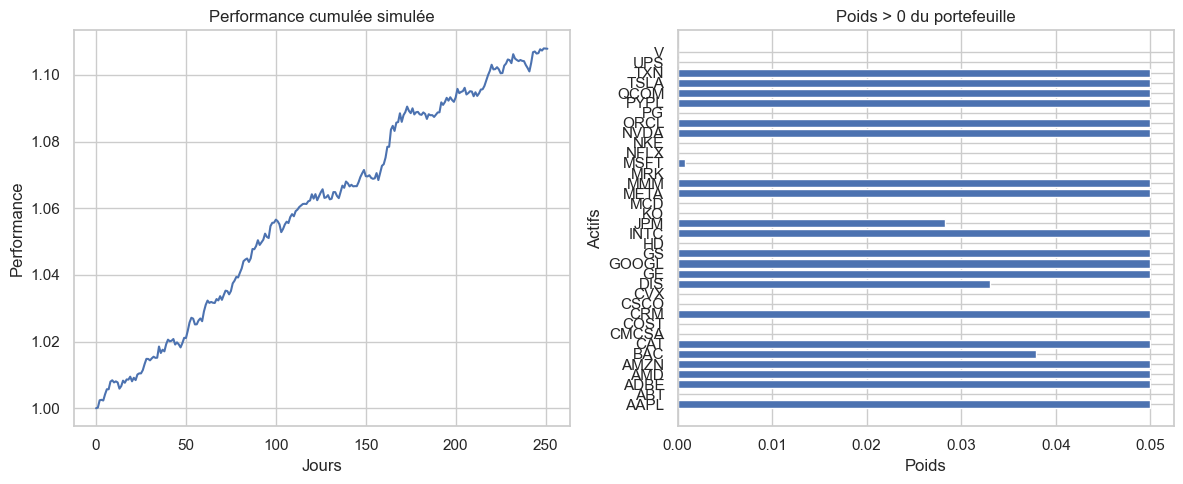

Rendement annuel attendu : 0.1048
Volatilité annuelle : 0.2900
Sharpe Ratio : 0.2924


In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Simule 1 ans de trading
n_days = 252 
np.random.seed(42)

# Rendements journaliers approx (annualisés divisés par 252)
daily_returns = expected_returns / 252
daily_cov = cov_matrix / 252

# Simule les rendements journaliers multivariés
simulated_returns = np.random.multivariate_normal(
    mean=daily_returns.values,
    cov=daily_cov.values,
    size=n_days
)

# Calcul rendements journaliers portefeuille
portf_daily_returns = simulated_returns.dot(optimal_weights.values)

# Performance cumulée
perf_cum = (1 + portf_daily_returns).cumprod()

# Calcul rendement, volatilité et Sharpe annualisés
ret_ann = np.dot(optimal_weights, expected_returns)
vol_ann = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix.values, optimal_weights))) * np.sqrt(252)
sharpe = (ret_ann - risk_free_rate) / vol_ann

# Affichage
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(perf_cum)
plt.title("Performance cumulée simulée")
plt.xlabel("Jours")
plt.ylabel("Performance")

plt.subplot(1,2,2)
# Filtrer poids > 0
weights_pos = optimal_weights[optimal_weights > 0]
plt.barh(weights_pos.index, weights_pos.values)
plt.title("Poids > 0 du portefeuille")
plt.xlabel("Poids")
plt.ylabel("Actifs")

plt.tight_layout()
plt.show()

print(f"Rendement annuel attendu : {ret_ann:.4f}")
print(f"Volatilité annuelle : {vol_ann:.4f}")
print(f"Sharpe Ratio : {sharpe:.4f}")
